# Season data research

From this website [Rhythm of food](http://rhythm-of-food.net) we know that there is a certain pattern between Google Trends data and the natural season of a fruit or vegetable. So I tried to fetch the trends since 2005 and compute the average for each month and plot them to check if there are any patterns.

In [2]:
import trends
df = trends.read_trends('./trends/en_us.csv')
df = df.astype('float64')
mean = df.groupby(df.index.month).mean()
mean.T



date                    1          2          3          4          5   \
Alfalfa Sprouts  60.428571  62.357143  60.642857  64.642857  58.928571   
Apple            31.071429  28.500000  30.214286  30.428571  28.142857   
Apricot          24.000000  23.285714  25.000000  26.571429  36.928571   
Artichoke        44.000000  51.357143  40.357143  45.785714  43.500000   
Asian Pear       50.642857  47.714286  60.357143  58.357143  51.642857   
...                    ...        ...        ...        ...        ...   
Waxed Beans       5.142857   4.214286   6.000000   8.285714   3.500000   
Yams              8.071429   6.428571   6.785714   8.214286   5.214286   
Yellow Squash    16.428571  14.071429  14.571429  17.071429  23.928571   
Cassava          21.714286  19.500000  28.500000  25.785714  19.642857   
Zucchini Squash  16.142857  15.142857  16.500000  20.000000  24.500000   

date                    6          7          8          9          10  \
Alfalfa Sprouts  53.714286  54.142857  54.357143  51.357143  45.428571   
Apple            25.142857  26.214286  31.357143  62.642857  78.285714   
Apricot          65.857143  72.571429  41.428571  23.785714  20.642857   
Artichoke        37.714286  37.928571  33.428571  33.928571  37.428571   
Asian Pear       42.357143  40.000000  56.857143  76.142857  67.785714   
...                    ...        ...        ...        ...        ...   
Waxed Beans       5.428571  16.785714  20.785714   9.642857  12.000000   
Yams              4.785714   5.000000   4.928571   6.142857   8.642857   
Yellow Squash    44.142857  70.142857  57.857143  30.214286  20.642857   
Cassava          15.000000  19.142857  16.142857  16.571429  27.571429   
Zucchini Squash  41.571429  62.000000  48.785714  27.571429  19.642857   

date                    11         12  
Alfalfa Sprouts  40.571429  41.357143  
Apple            76.857143  40.285714  
Apricot          26.714286  27.000000  
Artichoke        57.642857  84.500000  
Asian Pear       54.142857  45.142857  
...                    ...        ...  
Waxed Beans       9.642857  12.642857  
Yams             86.214286  22.000000  
Yellow Squash    18.214286  12.857143  
Cassava          15.928571  15.000000  
Zucchini Squash  16.428571  12.500000  

[133 rows x 12 columns]

If we try to plot the results for popular fruits as the Apple, we can see a peak between the months of August and December. And this in fact true for the state of [California](https://www.seasonalfoodguide.org/apples/california), but if we check other states with different climate conditions this varies subtle but stays near these months, as for [Alaska](https://www.seasonalfoodguide.org/apples/alaska).

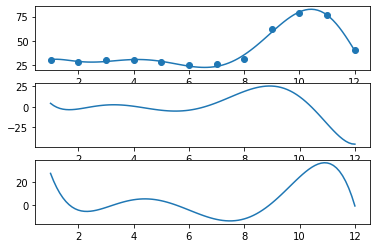

In [3]:
trends.plot_food_poly(mean['Apple'], deg=7) # Apples

And this apperantly works for other popular fruits as the [Mangoes](https://www.seasonalfoodguide.org/mangoes/florida).

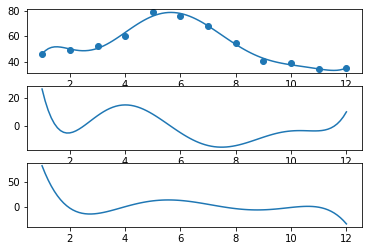

In [4]:
trends.plot_food_poly(mean['Mangos'], deg=7) # Mangoes

And this may give us an idea of when is approximately the peak season of a specific food, because people should look up for that food more those specific months.

But this works only with countries where the amount of people looking in Google for that food is enough to give meaningful data. And the results depends also of the language of the Country so the results of "Apples" for Spain should be different from "Manzanas".

---

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import util
import pyseason

In [2]:
df = pd.read_csv('./seasons.csv')

In [3]:
index_cols = ['State', 'Food']
dfs = [ df[index_cols] ]

for x in util.MONTHS:
    e = df['Early ' + x]
    l = df['Late '  + x]
    s = (e + l) / 2
    s.name = x
    dfs.append(s)  

df = pd.concat(dfs, axis=1)
df = df.melt(id_vars=['State', 'Food'], var_name=['Month'])
df.columns = ['State', 'Food', 'Month', 'Season']

In [3]:
wf = pd.read_csv('./weather/us_states.csv')
wf = pyseason.process_weather_df(wf)

In [5]:
melted_weather = wf.melt(
    id_vars=['State', 'Column'], value_vars=util.MONTHS, var_name='Month')

In [11]:
print(melted_weather)

           State                                        Column     Month  \
0        Alabama                         Average Precipitation   January   
1        Alabama     Average Number of Days With Precipitation   January   
2        Alabama          Most Precipitation Reported in a Day   January   
3        Alabama  Avg. No. of Days w/Precip. Above 0.1in/2.5mm   January   
4        Alabama    Avg. No. of Days w/Precip. Above 0.2in/5mm   January   
...          ...                                           ...       ...   
6921019  Wyoming        Maximum Daily Solar Radiation - Direct  December   
6921020  Wyoming        Minimum Daily Solar Radiation - Global  December   
6921021  Wyoming       Minimum Daily Solar Radiation - Diffuse  December   
6921022  Wyoming     Minimum Daily Solar Radiation - Reflected  December   
6921023  Wyoming        Minimum Daily Solar Radiation - Direct  December   

         value  
0        131.0  
1          8.0  
2        129.5  
3          6.9  
4 

In [6]:
melted_weather = melted_weather[melted_weather.Column.isin(util.WEATHER_DATA)]
melted_weather['State'] = melted_weather['State'].map(util.US_STATES_CODES)

In [7]:
mean = melted_weather.groupby(['State', 'Month', 'Column'])['value'].mean()

Interpolate months for each feature

In [8]:
months = mean.unstack('Month')[util.MONTHS]
months.interpolate('linear', limit_direction='both', axis=1, inplace=True)

Seems that there is a lot missing Growing Degree Data, I may delete that feature

In [9]:
wf = months.stack().unstack('Column')[util.WEATHER_DATA]
wf = df.set_index(['State', 'Month']).join(wf)
wf.reset_index(inplace=True)

Now that we have the features and labels associated we can write them into a file

In [276]:
wf.to_csv('./data.csv', index=None)

---

In [132]:
import matplotlib.pyplot as plt
import altair as alt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Select feature that best cluster data together using TSNE to visualize high dimensional data in 2d space

In [829]:
WEATHER_DATA = [
    'Average Daily Solar Radiation - Diffuse',
    'Average Daily Solar Radiation - Direct',
    'Average Daily Solar Radiation - Global',
    'Average Daily Solar Radiation - Reflected',
    'Average High Temperature',
    'Average Length of Day',
    'Average Low Temperature',
#    'Average Number of Days With Precipitation',
    'Average Precipitation',
    'Average Temperature',
#    'Avg. No. of Days w/Precip. Above 0.1in/2.5mm',
#    'Avg. No. of Days w/Precip. Above 0.5in/13mm',
#    'Cooling Degree Days',
#    'Growing Degree Days',
    'Highest Recorded Temperature',
    'Lowest Recorded Temperature',
#    'Maximum Daily Solar Radiation - Diffuse',
#    'Maximum Daily Solar Radiation - Direct',
#    'Maximum Daily Solar Radiation - Global',
#    'Maximum Daily Solar Radiation - Reflected',
#    'Minimum Daily Solar Radiation - Diffuse',
#    'Minimum Daily Solar Radiation - Direct',
#    'Minimum Daily Solar Radiation - Global',
#    'Minimum Daily Solar Radiation - Reflected',
]

In [830]:
ff = wf.set_index('Food').loc['Mangoes']

Add N random distributed samples with based on the mean and std of each feature

In [831]:
freq = 0.2 # Season frequency target
n = int((len(ff) * freq - len(ff[ff.Season > 0])) // ( 1 - freq ))

In [832]:
n = n if n > 0 else 0

In [833]:
# extract mean and std for each feature a generate n normal samples
d = ff[ff.Season > 0][WEATHER_DATA].describe()
X_augmented = np.random.normal(d.loc['mean'], d.loc['std'], (n, len(d.columns)))

In [834]:
augmented = pd.DataFrame(X_augmented)
augmented.columns = WEATHER_DATA
augmented['Season'] = 1.0
augmented['State']  = None
augmented['Month']  = None

In [835]:
ff = pd.concat([ff, augmented], sort=False)

In [836]:
ff

State     Month  Season  Average Daily Solar Radiation - Diffuse  \
Mangoes    AK     April     0.0                                 7.059223   
Mangoes    AK    August     0.0                                 7.816019   
Mangoes    AK  December     0.0                                 0.516199   
Mangoes    AK  February     0.0                                 2.094660   
Mangoes    AK   January     0.0                                 0.765128   
...       ...       ...     ...                                      ...   
127      None      None     1.0                                 6.691692   
128      None      None     1.0                                 7.495101   
129      None      None     1.0                                 7.615355   
130      None      None     1.0                                 7.968648   
131      None      None     1.0                                 5.883824   

         Average Daily Solar Radiation - Direct  \
Mangoes                               16.325000   
Mangoes                               12.951214   
Mangoes                                1.787833   
Mangoes                                5.683495   
Mangoes                                2.731129   
...                                         ...   
127                                   27.268311   
128                                   26.091604   
129                                   27.238825   
130                                   23.627507   
131                                   19.044538   

         Average Daily Solar Radiation - Global  \
Mangoes                               13.853398   
Mangoes                               13.563592   
Mangoes                                0.615978   
Mangoes                                3.226456   
Mangoes                                1.054040   
...                                         ...   
127                                   22.280811   
128                                   19.043471   
129                                   18.479872   
130                                   18.421341   
131                                   24.272324   

         Average Daily Solar Radiation - Reflected  Average High Temperature  \
Mangoes                                  16.932524                  4.374430   
Mangoes                                  13.619660                 16.072569   
Mangoes                                   1.964486                 -7.640506   
Mangoes                                   6.572573                 -6.436020   
Mangoes                                   3.017436                 -8.893750   
...                                            ...                       ...   
127                                      22.396541                 26.819682   
128                                      21.002116                 24.139685   
129                                      24.956611                 29.652345   
130                                      22.274601                 23.471944   
131                                      23.175235                 26.514292   

         Average Length of Day  Average Low Temperature  ...  \
Mangoes              15.909709                -5.907969  ...   
Mangoes              16.893932                 6.753250  ...   
Mangoes               6.402494               -15.223797  ...   
Mangoes               9.809223               -15.111500  ...   
Mangoes               7.336908               -16.498747  ...   
...                        ...                      ...  ...   
127                  14.397555                10.374193  ...   
128                  13.217810                16.259305  ...   
129                  13.102364                22.876945  ...   
130                  13.547565                16.284457  ...   
131                  12.690569                16.162626  ...   

         Highest Recorded Temperature  Lowest Recorded Temperature  \
Mangoes                     20.755780                   -14.171261   

In [837]:
X = ff[WEATHER_DATA].values
y = ff['Season'].values

In [838]:
scaler = preprocessing.StandardScaler()
pca = PCA(n_components=3)

In [839]:
X_scaled = preprocessing.scale(X)
X_embedded = pca.fit_transform(X_scaled)

# X_scaled = X
# X_embedded = X

In [840]:
ff['X Component'] = X_embedded[:,0]
ff['Y Component'] = X_embedded[:,1]
ff['Z Component'] = X_embedded[:,2]

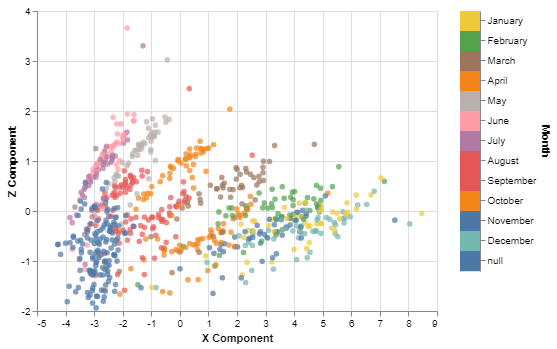

In [841]:
select = alt.selection_multi(fields=['Month'])
color = alt.condition(
    select,
    alt.Color('Month:N', legend=None),
    alt.value('lightgray')
)

scatter = alt.Chart(ff).mark_circle(size=30).encode(
    x='X Component',
    y='Z Component',
    color=color,
    tooltip=['State', 'Month']
).interactive()

legend = alt.Chart(ff).mark_rect().encode(
    y=alt.Y('Month:N', axis=alt.Axis(orient='right'), sort=util.MONTHS),
    color=color
).add_selection(select)

scatter | legend

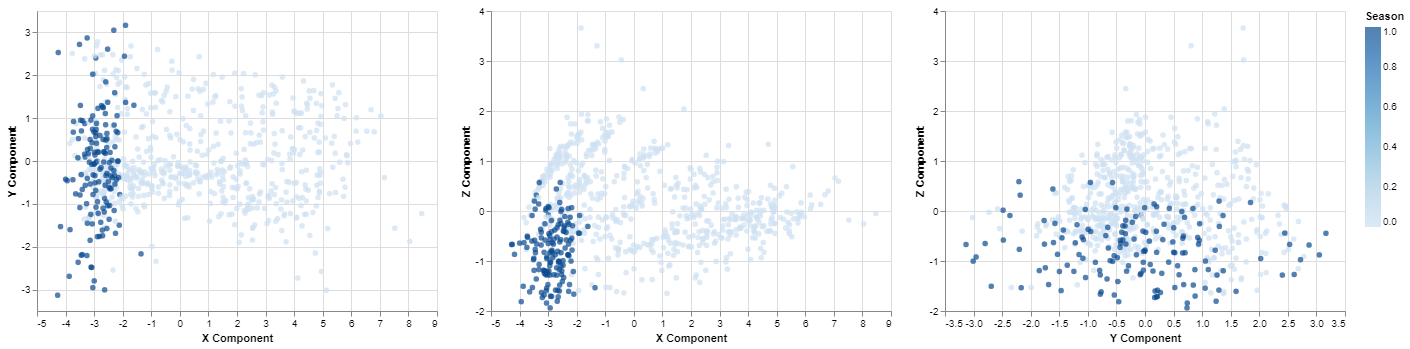

In [842]:
season_xy = alt.Chart(ff).mark_circle(size=30).encode(
    x='X Component',
    y='Y Component',
    color='Season',
    tooltip=['State', 'Month'] + WEATHER_DATA
).interactive()

season_xz = alt.Chart(ff).mark_circle(size=30).encode(
    x='X Component',
    y='Z Component',
    color='Season',
    tooltip=['State', 'Month'] + WEATHER_DATA
).interactive()

season_yz = alt.Chart(ff).mark_circle(size=30).encode(
    x='Y Component',
    y='Z Component',
    color='Season',
    tooltip=['State', 'Month'] + WEATHER_DATA
).interactive()

(season_xy | season_xz | season_yz )

In [843]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [844]:
y = (ff['Season'] > 0).astype('int64').values

In [845]:
clf = SVR(kernel='linear', gamma='auto')

In [868]:
clf = KNeighborsRegressor(weights='uniform')
# clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1)

In [869]:
cross_val_score(clf, X_embedded, y, cv=5)

array([ 0.29981203,  0.        ,  0.        ,  0.        , -3.24659091])

In [870]:
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.3)
clf.fit(X_train, y_train)
# clf.fit(X_embedded, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [871]:
clf.score(X_test, y_test)

0.7339317692394877

Predict season data from other country based on weather information

In [872]:
pwf = pd.read_csv('./weather/south_america.csv', low_memory=False)
pwf = pyseason.process_weather_df(pwf)

In [873]:
melted_weather = pwf.melt(
    id_vars=['Country', 'Column'], value_vars=util.MONTHS, var_name='Month')

In [874]:
melted_weather = melted_weather[melted_weather.Column.isin(util.WEATHER_DATA)]

In [875]:
mean = melted_weather.groupby(['Country', 'Month', 'Column'])['value'].mean()

Interpolate months for each feature

In [876]:
months = mean.unstack('Month')[util.MONTHS]
months.interpolate('linear', limit_direction='both', axis=1, inplace=True)

Seems that there is a lot missing Growing Degree Data, I may delete that feature

In [877]:
pwf = months.stack().unstack('Column')[util.WEATHER_DATA]
pwf.reset_index(inplace=True)

In [878]:
X_predict = pwf[WEATHER_DATA].values
X_predict_scaled = preprocessing.scale(X_predict)
X_predict_embedded = pca.transform(X_predict_scaled)

prediction = clf.predict(X_predict_embedded)
pwf['Season'] = prediction

In [879]:
# X_predict_embedded = X_predict

In [880]:
pwf['X Component'] = X_predict_embedded[:,0]
pwf['Y Component'] = X_predict_embedded[:,1]

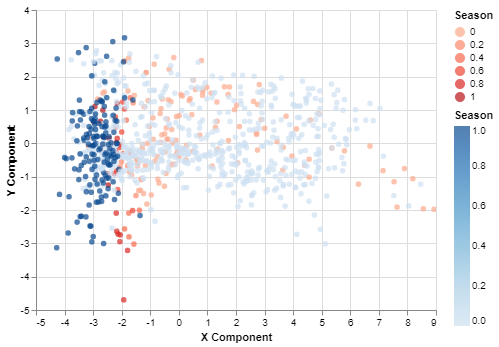

In [881]:
south_america = alt.Chart(pwf).mark_circle(size=30).encode(
    x='X Component',
    y='Y Component',
    color=alt.Color('Season:O', scale=alt.Scale(scheme='reds')),
    tooltip=['Country', 'Month', 'Average Temperature', 'Average Precipitation']
).interactive()

united_states = alt.Chart(ff).mark_circle(size=30).encode(
    x='X Component',
    y='Y Component',
    color=alt.Color('Season:Q', scale=alt.Scale(scheme='blues')),
    tooltip=['State', 'Month', 'Average Temperature', 'Average Precipitation']
).interactive()

south_america + united_states

In [882]:
pwf[['Country', 'Month', 'Season']].pivot(index='Country', columns='Month', values='Season')[util.MONTHS]

Month                                         January  February  March  April  \
Country                                                                         
Argentina                                         0.2       0.6    0.0    0.0   
Bolivia                                           0.0       0.0    0.0    0.0   
Brazil                                            0.8       0.6    0.0    0.0   
Chile                                             0.2       0.2    0.0    0.0   
Colombia                                          0.0       0.0    0.0    0.0   
Ecuador                                           0.0       0.0    0.0    0.0   
Falkland Islands                                  0.0       0.0    0.0    0.0   
French Guiana                                     0.4       0.4    0.8    0.8   
Guyana                                            0.0       0.2    0.4    0.6   
Paraguay                                          0.2       0.2    0.0    0.0   
Peru                                              0.0       0.0    0.0    0.0   
South Georgia and The South Sandwich Islands      0.0       0.0    0.0    0.0   
Suriname                                          0.2       0.2    0.2    0.6   
Uruguay                                           0.0       0.4    0.0    0.0   
Venezuela                                         0.0       0.2    0.6    0.6   

Month                                         May  June  July  August  \
Country                                                                 
Argentina                                     0.0   0.0   0.0     0.0   
Bolivia                                       0.0   0.0   0.0     0.0   
Brazil                                        0.0   0.0   0.0     0.0   
Chile                                         0.0   0.0   0.0     0.0   
Colombia                                      0.0   0.0   0.0     0.0   
Ecuador                                       0.0   0.0   0.0     0.0   
Falkland Islands                              0.0   0.0   0.0     0.0   
French Guiana                                 0.8   0.8   0.8     1.0   
Guyana                                        0.4   0.4   0.8     1.0   
Paraguay                                      0.0   0.0   0.0     0.0   
Peru                                          0.0   0.0   0.0     0.0   
South Georgia and The South Sandwich Islands  0.0   0.0   0.0     0.0   
Suriname                                      0.8   0.8   1.0     1.0   
Uruguay                                       0.0   0.0   0.0     0.0   
Venezuela                                     0.6   0.2   0.6     0.8   

Month                                         September  October  November  \
Country                                                                      
Argentina                                           0.0      0.0       0.0   
Bolivia                                             0.0      0.0       0.0   
Brazil                                              0.4      1.0       0.6   
Chile                                               0.0      0.0       0.0   
Colombia                                            0.0      0.0       0.0   
Ecuador                                             0.0      0.0       0.0   
Falkland Islands                                    0.0      0.0       0.0   
French Guiana                                       1.0      1.0       1.0   
Guyana                                              1.0      1.0       0.0   
Paraguay                                            0.0      0.0       0.0   
Peru                                                0.0      0.0       0.0   
South Georgia and The South Sandwich Islands        0.0      0.0       0.0   
Suriname                                            1.0      1.0       1.0   
Uruguay                                             0.0      0.0       0.0   
Venezuela                                           0.8      0.2       0.0   

Month                                         Decembe

---

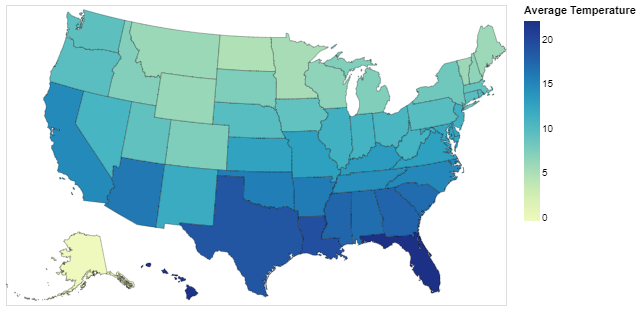

In [53]:
# Fetch id from each State here
from vega_datasets import data
states = data.population_engineers_hurricanes()

maped = ff.State.map({ v: k for k, v in util.US_STATES_CODES.items() })
maped = maped.map(states.set_index('state').id)
ff['id'] = maped

states = alt.topo_feature(data.us_10m.url, feature='states')
combined = ff.groupby('State').mean().reset_index()

# US states background
background = alt.Chart(states).mark_geoshape(
    stroke='black',
    strokeWidth=0.25
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(combined, 'id', ['State', 'Season', 'Average Temperature'])
).encode(
    fill='Average Temperature:Q',
    tooltip=['State:N']
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)
background